# Model training

## Import libraries

The following command must be executed for balancing:

```conda install -c conda-forge imbalanced-learn```

In [1]:
from enum import Enum
import math
import win32com.client as win32

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, fbeta_score, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy import stats
from imblearn.over_sampling import RandomOverSampler

outlook = win32.Dispatch('outlook.application')


In [2]:
# Tensorflow may not be installed on every system
import tensorflow as tf
from scikeras.wrappers import KerasClassifier

## Methods

In [3]:
def truncate(number, digits) -> float:
    # Helper method that truncate scores to four decimals
    nbDecimals = len(str(number).split('.')[1])
    if nbDecimals <= digits:
        return number
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper


def get_nested(data, *args):
    # Helper method that returns the value of a nested dictionary
    if args and data:
        element  = args[0]
        if element:
            value = data.get(element)
            return value if len(args) == 1 else get_nested(value, *args[1:])
    return None


def get_scores(y_test, y_predicted):
    # Method that returns different scores for the passed parameters
    digits = 4
    scores = {
        'Accuracy': truncate(accuracy_score(y_test, y_predicted), digits),
        'Recall': truncate(recall_score(y_test, y_predicted), digits),
        'Precision': truncate(precision_score(y_test, y_predicted), digits),
        'F1 score': truncate(f1_score(y_test, y_predicted), digits),
        'F2 score': truncate(fbeta_score(y_test, y_predicted, beta=2), digits)
    }
    return scores


def print_scores(all_scores):
    # Method that prints a table of the passed scores
    header_row = "{header:<20}".format(header="Estimator")
    for score in list(all_scores.values())[0]:
        header_row+="{header:>15}".format(header=score)
    print(header_row,"\n")

    for estimator in all_scores.keys():
        current_row = "{estimator:<20}".format(estimator=estimator)
        estimator_scores = all_scores.get(estimator)
        for score in estimator_scores:
            score_value = get_nested(all_scores, estimator, score)
            current_row+="{score_value:>15}".format(score_value=score_value)
        print(current_row)
        

def print_best_params(estimator_params):
    # Method that prints the best parameters
    for estimator in estimator_params.keys():
        print("Best parameters for "+estimator+": ")
        parameters = estimator_params.get(estimator)
        for parameter in parameters:
            print(parameter+": "+str(get_nested(estimator_params, estimator, parameter)))
            

def plot_roc(title, ax, y_test, y_predicted):
    # Method that plots the ROC for the passed parameters
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_predicted)
    ax.plot(false_positive_rate, true_positive_rate)
    ax.plot([0, 1], ls="--")
    ax.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")

    ax.set_title('Receiver Operating Characteristic (ROC) - '+title)
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    

def plot_feature_importance(title, ax, estimator, X_train):
    # Method that plots the feature importance for the passed parameters
    feat_importance = pd.Series(estimator.feature_importances_, index=X_train.columns)
    feat_importance.nlargest(12).plot(kind='barh', ax=ax)

    ax.set_title('Feature Importance for '+title)


def plot_learning_curve(title, estimator, ax, X, y, cv, scoring=None):
    # Method that plots the learning curve for the passed parameters
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=4,
        train_sizes=np.linspace(0.1, 1.0, 5),
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.grid()
    ax.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    ax.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    ax.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")

    ax.set_title("Learning Curve: "+title)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.legend()
    
    
def plot_loss(title, history):
    # list all data in history
    print(history.history.keys())
    # summarize history for recall
    for metric in history.history.keys():
        if not str(metric).startswith("val"):
            plt.plot(history.history[metric])
            plt.plot(history.history['val_'+metric])
            plt.title(title + 'model ' + metric)
            plt.ylabel(metric)
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            plt.show()


def send_mail_via_outlook(message:str):
    mail = outlook.CreateItem(0)
    mail.To = 'florian.v.lang@gmx.de'
    mail.Subject = 'Estimator done!'
    mail.Body = message
    #mail.HTMLBody = '<h2>HTML Message body</h2>' #this field is optional
    # To attach a file to the email (optional):
    # attachment  = "Path to the attachment"
    # mail.Attachments.Add(attachment)
    mail.Send()
        

def model_evaluate(estimator, parameters, X_train, X_test, y_train, y_test, cv_folds=2, n_jobs=-1, do_send_notification_mail=False):
    # Method that trains the passed model with the passed parameters and plots the evaluation of it
    scoring = make_scorer(fbeta_score, beta=2)

    # create the grid search instance
    grid_search_estimator = GridSearchCV(estimator=estimator.value,
                                         param_grid=parameters,
                                         scoring= scoring,
                                         cv=cv_folds,
                                         return_train_score=True,
                                         verbose=3,
                                         n_jobs=n_jobs
                                         )
    # training and prediction
    fitted_estimator_grid = grid_search_estimator.fit(X_train, y_train)
    best_fitted_estimator = fitted_estimator_grid.best_estimator_
    y_predicted = fitted_estimator_grid.predict(X_test)
    
    # evaluation of the model
    print_scores({estimator.name: get_scores(y_test, y_predicted)})
    print_best_params({estimator.name: fitted_estimator_grid.best_params_})

    figure = plt.figure(figsize=(15, 15))
    figure_index = 1
    number_of_rows = 2
    number_of_columns = 2
    
    # plot roc
    ax = figure.add_subplot(number_of_rows, number_of_columns, figure_index)
    plot_roc(title=estimator.name, ax=ax, y_test=y_test, y_predicted=y_predicted)
    figure_index += 1
    
    # plot feature importance in case of forest estimator
    if estimator==Estimator.forest_estimator:
        ax = figure.add_subplot(number_of_rows, number_of_columns, figure_index)
        plot_feature_importance(title=estimator.name, ax=ax, estimator=fitted_estimator_grid.best_estimator_, X_train=X_train)
        figure_index += 1
        
    if estimator==Estimator.log_regr_estimator:
        headers = ["Coefficient", "value"]
        print_template = ""
        for i in range(len(headers)):
            k = len(headers[i])
            print_template += "{" + str(i) + ":" + str(k+5) + "}|"
        print(print_template.format(*headers))
        print(print_template.format("intercept", best_fitted_estimator.intercept_[0]))
        i = 0
        for coef in best_fitted_estimator.coef_[0]:
            feature_name = best_fitted_estimator.feature_names_in_[i]
            print(print_template.format(feature_name, round(coef, 5)))
            i += 1
    plt.show()
    
    if do_send_notification_mail:
        send_mail_via_outlook("The estimator {} was fitted with params: {}".format(estimator.name, fitted_estimator_grid.best_params_))
        
    return fitted_estimator_grid

## Setup data

Load preprocessed dataset and create objects X and y to store the data and the target value. Then split data into training data and testing data.

In [4]:
# choose parameters
use_reduced_ds = True
use_sample = False

# Load dataset
if use_reduced_ds:
    heart_dataset = pd.read_csv('./heart_dataset_preprocessed_reduced.csv')
else:
    heart_dataset = pd.read_csv('./heart_dataset_preprocessed.csv')
print(heart_dataset.columns)
if use_sample:
    sample_size = 30000
    selected_data = heart_dataset.sample(n=sample_size, random_state=3)
else:
    selected_data = heart_dataset
print("Size of dataset: {}".format(heart_dataset.shape[0]))
# Split and reduce dataset (reduction only for test purposes)
X = selected_data.drop(columns='HeartDisease')
y = selected_data['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

# Balance training data
X_train_oversampled, y_train_oversampled = RandomOverSampler().fit_resample(X_train, y_train)

data_dict = {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}
data_dict_oversampled = {"X_train": X_train_oversampled, "X_test": X_test, "y_train": y_train_oversampled, "y_test": y_test}

Index(['HeartDisease', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex',
       'AgeCategory', 'Diabetic', 'PhysicalActivity', 'KidneyDisease',
       'SkinCancer', 'breathing_risk', 'BMI_sqrt', 'GenHealth_squared',
       'GenHealth_squared_x_Age', 'GenHealth_squared_x_PhysicalHealth',
       'PhysicalHealth__x_DiffWalking', 'PhysicalHealth_binned'],
      dtype='object')
Size of dataset: 319795


## Baseline

We define a baseline model as a reference to the actual model with DummyClassifier from Scikit-Learn. Because our data is very imbalanced, we are using the stratified strategy.

Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

Dummy Classifier             0.8415         0.0814         0.0803         0.0809         0.0812


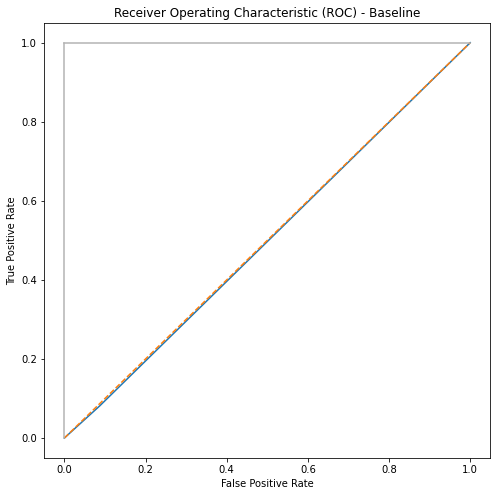

In [5]:
dummy_classifier = DummyClassifier(strategy='stratified')
dummy_classifier.fit(X_train, y_train)
y_predicted = dummy_classifier.predict(X_test)

print_scores({'Dummy Classifier':get_scores(y_test, y_predicted)})
plot_roc(title='Baseline', ax=plt.figure(figsize=(8, 8)).add_subplot(), y_test=y_test, y_predicted=y_predicted)
plt.show()

**Conclusion**

We achieve an 0.84 accuracy, a 0.09 recall, a 0.09 precision and a 0.09 F1-Score. Plotting the ROC curve shows that the baseline classifier is not really better than a random classifier


## Model selection

To find out which modeling method with which parameters best fits to our task, we define a set of modeling methods, train them with different parameters (hyperparameter tuning) and evaluate the results.

In [5]:
# Create DNN model
def create_model(dropout_rate, hidden_layer_sizes=(20, 20), activation='relu'):
    # create model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train.columns.size,)))
    
    for hidden_layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(hidden_layer_size, activation=activation))
    
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
              
    return model

# Enumeration class containing all estimators we want to consider for classification
class Estimator(Enum):
    knn_estimator=KNeighborsClassifier()
    forest_estimator=RandomForestClassifier(random_state=42)
    svc_estimator=SVC(random_state=42)
    log_regr_estimator=LogisticRegression(random_state=42)
    dnn_estimator=KerasClassifier(model=create_model, verbose=0, hidden_layer_sizes=(30, 30), activation='sigmoid', dropout_rate=0.0)
    xgb_estimator=GradientBoostingClassifier(random_state=42)

# Class Weights calculation
neg, pos = np.bincount(y_train)
total = neg + pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

# Dictionary of parameter grids of the estimators
weights_ls = [{0:1, 1:1}, {0:1, 1:4}, {0: weight_for_0, 1: weight_for_1}]
n_estimators_ls_tree_models = [50, 100, 200, 800, 1000]
max_features_ls_tree_models = ['sqrt', 'log2']
validation_fraction_tree_models = [0.3]
n_iter_no_change_tree_models = [50]

param_grids = {
    Estimator.knn_estimator: {
        'n_neighbors': [2, 3, 4, 5]
    },
    Estimator.forest_estimator: {
        'class_weight': weights_ls,
        'n_estimators': n_estimators_ls_tree_models, 
        'max_features': max_features_ls_tree_models,
        'min_samples_split': [10],
        'max_samples': [1000, None],
        'n_jobs': [-1]
    },
    Estimator.svc_estimator: {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'class_weight': weights_ls
    },
    Estimator.dnn_estimator: {
        'batch_size': [512],
        'epochs': [100, 300],
        'hidden_layer_sizes': [(20,20), (60,30), (40,20,10)],
        'activation': ['relu'],
        'loss': ['binary_crossentropy'],
        'optimizer': ['SGD', 'adam'],
        'class_weight': weights_ls,
        'dropout_rate': [0.4]
    },
    Estimator.xgb_estimator: {
        'n_estimators': n_estimators_ls_tree_models,
        'loss': ['log_loss'], # like advised in scikit-learn documentation
        'criterion': ['friedman_mse'], # like advised in scikit-learn documentation
        'max_depth': [3, 5, 10, 20],
        'max_features': max_features_ls_tree_models,
        'max_leaf_nodes': [5, 10, None],
        'validation_fraction': validation_fraction_tree_models,
        'n_iter_no_change': n_iter_no_change_tree_models
    },
    Estimator.log_regr_estimator: {
        'solver': ['sag', 'saga', 'lbfgs'], # TODO check also saga with elasticnet
        'max_iter': [200, 400, 1000], 
        'class_weight': weights_ls
    }
}

Fitting 2 folds for each of 36 candidates, totalling 72 fits
Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

dnn_estimator                0.7151          0.821         0.2068         0.3304          0.515
Best parameters for dnn_estimator: 
activation: relu
batch_size: 512
class_weight: {0: 0.5468029990852277, 1: 5.841538040003653}
dropout_rate: 0.4
epochs: 300
hidden_layer_sizes: (60, 30)
loss: binary_crossentropy
optimizer: SGD


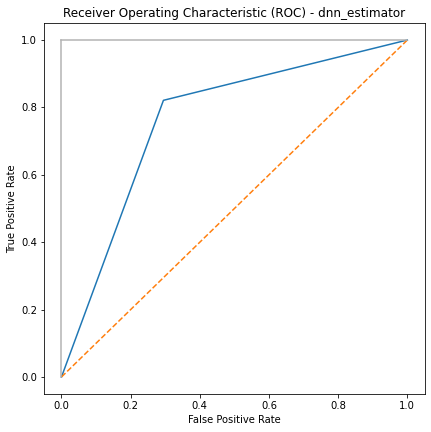

In [7]:
# dnn estimator
estimator = Estimator.dnn_estimator
grid = model_evaluate(estimator, param_grids.get(estimator), **data_dict)

Fitting 2 folds for each of 120 candidates, totalling 240 fits
Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

xgb_estimator                0.8535         0.3052         0.2309         0.2629         0.2867
Best parameters for xgb_estimator: 
criterion: friedman_mse
loss: log_loss
max_depth: 20
max_features: sqrt
max_leaf_nodes: None
n_estimators: 100
n_iter_no_change: 50
validation_fraction: 0.3


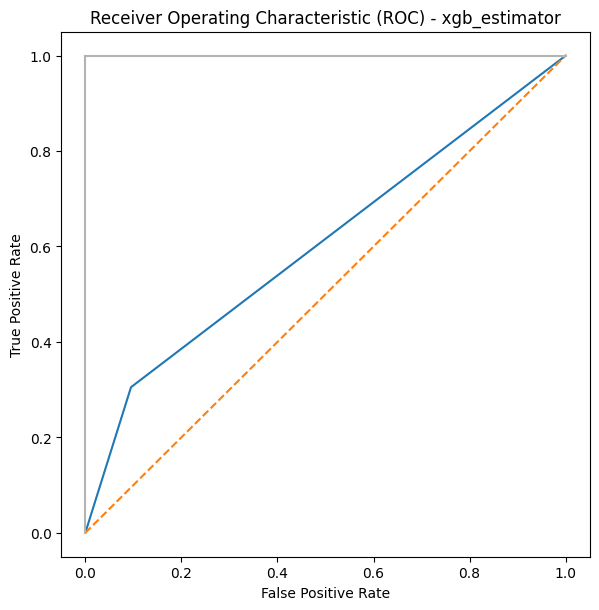

In [15]:
# XGBoost estimator
estimator = Estimator.xgb_estimator
grid = model_evaluate(estimator, param_grids.get(estimator), **data_dict_oversampled)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

knn_estimator                0.8426         0.3817         0.2383         0.2934         0.3407
Best parameters for knn_estimator: 
n_neighbors: 3


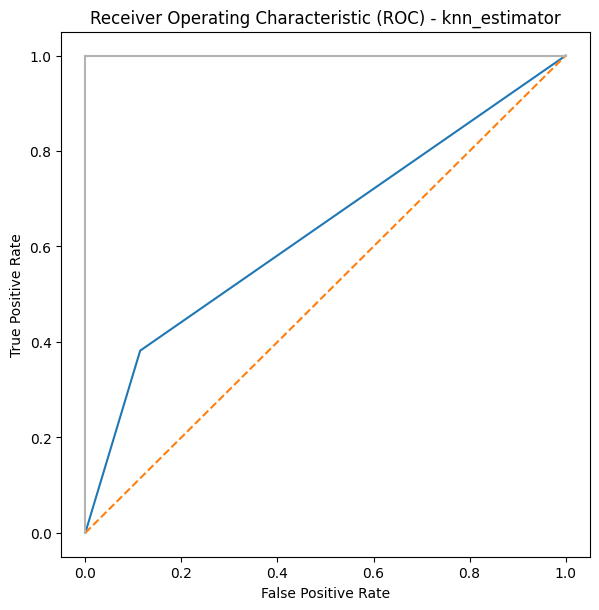

GridSearchCV(cv=2, estimator=KNeighborsClassifier(), n_jobs=12,
             param_grid={'n_neighbors': [2, 3, 4, 5]}, return_train_score=True,
             scoring=make_scorer(fbeta_score, beta=2), verbose=3)

In [16]:
# knn estimator
estimator = Estimator.knn_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict_oversampled)

Fitting 2 folds for each of 60 candidates, totalling 120 fits
Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

forest_estimator             0.8528         0.4306         0.2726         0.3338         0.3859
Best parameters for forest_estimator: 
class_weight: {0: 0.5468029990852277, 1: 5.841538040003653}
max_features: sqrt
max_samples: None
min_samples_split: 10
n_estimators: 1000
n_jobs: -1


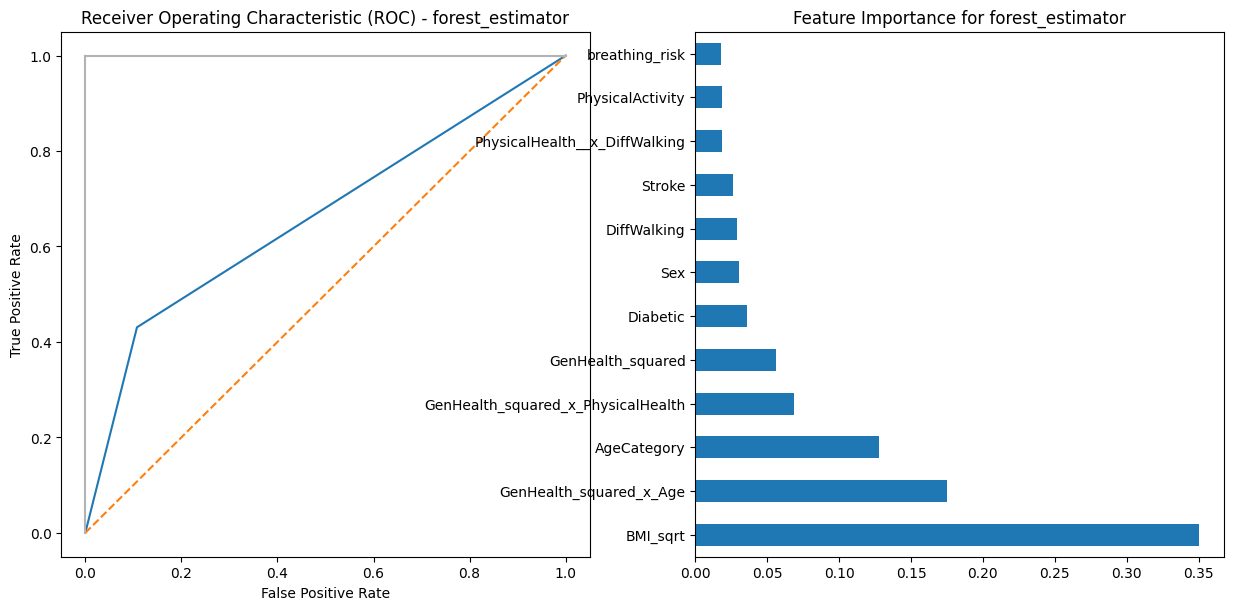

GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42), n_jobs=12,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 4},
                                          {0: 0.5468029990852277,
                                           1: 5.841538040003653}],
                         'max_features': ['sqrt', 'log2'],
                         'max_samples': [1000, None], 'min_samples_split': [10],
                         'n_estimators': [50, 100, 200, 800, 1000],
                         'n_jobs': [-1]},
             return_train_score=True, scoring=make_scorer(fbeta_score, beta=2),
             verbose=3)

In [19]:
# random forest estimator
estimator = Estimator.forest_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

svc_estimator                0.7355          0.791         0.2154         0.3386         0.5155
Best parameters for svc_estimator: 
class_weight: {0: 0.5468029990852277, 1: 5.841538040003653}
kernel: poly


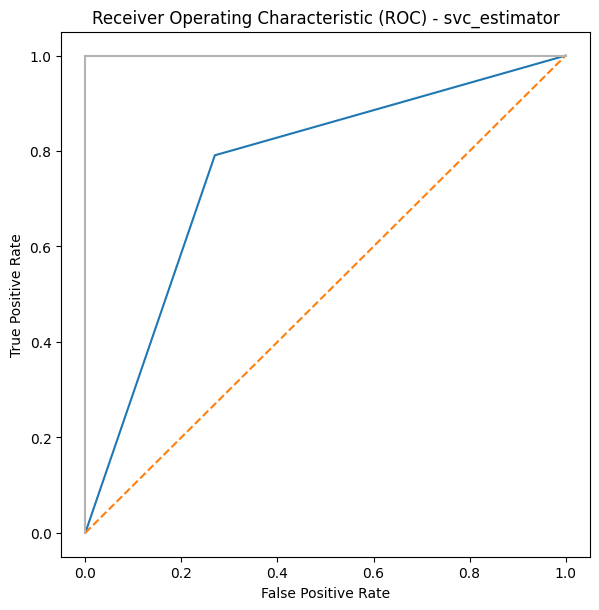

GridSearchCV(cv=2, estimator=SVC(random_state=42), n_jobs=12,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 4},
                                          {0: 0.5468029990852277,
                                           1: 5.841538040003653}],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             return_train_score=True, scoring=make_scorer(fbeta_score, beta=2),
             verbose=3)

In [20]:
# svc estimator
estimator = Estimator.svc_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict)

## Keras plain model
Train keras model with the identified parameters, to take a closer look at the loss and learning curve.

In [6]:
estimator = Estimator.dnn_estimator
estimator_name = "Keras estimator DNN"
dropout_rate = 0.4
activation = 'relu'
hidden_layer_sizes=(60,30)
loss = "binary_crossentropy"
metrics= [tf.keras.metrics.Recall()]
class_weight = {0: weight_for_0, 1: weight_for_1}
epochs = 300
batch_size = 512
optimizer = "SGD"
validation_split_fraction = 0.2

model = create_model(dropout_rate=dropout_rate, hidden_layer_sizes=hidden_layer_sizes, activation=activation)
model.compile(optimizer, loss=loss, metrics=metrics)

history = model.fit(X_train, y_train, epochs=epochs, validation_split=validation_split_fraction, batch_size=batch_size, class_weight=class_weight)

Epoch 1/300
400/400 [==============================] - 1s 2ms/step - loss: 0.6391 - recall: 0.7611 - val_loss: 0.6200 - val_recall: 0.7502
Epoch 2/300
400/400 [==============================] - 1s 2ms/step - loss: 0.5893 - recall: 0.7152 - val_loss: 0.5871 - val_recall: 0.7428
Epoch 3/300
400/400 [==============================] - 1s 2ms/step - loss: 0.5683 - recall: 0.7267 - val_loss: 0.5644 - val_recall: 0.7439
Epoch 4/300
400/400 [==============================] - 1s 2ms/step - loss: 0.5551 - recall: 0.7321 - val_loss: 0.5507 - val_recall: 0.7502
Epoch 5/300
400/400 [==============================] - 1s 2ms/step - loss: 0.5449 - recall: 0.7420 - val_loss: 0.5459 - val_recall: 0.7638
Epoch 6/300
400/400 [==============================] - 1s 2ms/step - loss: 0.5375 - recall: 0.7496 - val_loss: 0.5381 - val_recall: 0.7701
Epoch 7/300
400/400 [==============================] - 1s 2ms/step - loss: 0.5327 - recall: 0.7586 - val_loss: 0.5236 - val_recall: 0.7699
Epoch 8/300
400/400 [======

400/400 [==============================] - 1s 2ms/step - loss: 0.4985 - recall: 0.8122 - val_loss: 0.4933 - val_recall: 0.8150
Epoch 60/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4994 - recall: 0.8136 - val_loss: 0.4951 - val_recall: 0.8178
Epoch 61/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4994 - recall: 0.8107 - val_loss: 0.4995 - val_recall: 0.8199
Epoch 62/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4992 - recall: 0.8113 - val_loss: 0.4989 - val_recall: 0.8192
Epoch 63/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4981 - recall: 0.8123 - val_loss: 0.4970 - val_recall: 0.8206
Epoch 64/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4995 - recall: 0.8126 - val_loss: 0.4976 - val_recall: 0.8206
Epoch 65/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4992 - recall: 0.8130 - val_loss: 0.4922 - val_recall: 0.8136
Epoch 66/300
400/400 [===========

400/400 [==============================] - 1s 2ms/step - loss: 0.4967 - recall: 0.8189 - val_loss: 0.4939 - val_recall: 0.8166
Epoch 118/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4966 - recall: 0.8164 - val_loss: 0.4977 - val_recall: 0.8185
Epoch 119/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4963 - recall: 0.8157 - val_loss: 0.5025 - val_recall: 0.8210
Epoch 120/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4967 - recall: 0.8151 - val_loss: 0.4974 - val_recall: 0.8171
Epoch 121/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4964 - recall: 0.8163 - val_loss: 0.4989 - val_recall: 0.8187
Epoch 122/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4966 - recall: 0.8172 - val_loss: 0.4969 - val_recall: 0.8182
Epoch 123/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4971 - recall: 0.8163 - val_loss: 0.4947 - val_recall: 0.8159
Epoch 124/300
400/400 [====

400/400 [==============================] - 1s 2ms/step - loss: 0.4959 - recall: 0.8183 - val_loss: 0.4898 - val_recall: 0.8129
Epoch 176/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4947 - recall: 0.8194 - val_loss: 0.4822 - val_recall: 0.8083
Epoch 177/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4943 - recall: 0.8142 - val_loss: 0.4947 - val_recall: 0.8157
Epoch 178/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4963 - recall: 0.8167 - val_loss: 0.4968 - val_recall: 0.8166
Epoch 179/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4951 - recall: 0.8167 - val_loss: 0.4905 - val_recall: 0.8129
Epoch 180/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4946 - recall: 0.8170 - val_loss: 0.4971 - val_recall: 0.8166
Epoch 181/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4949 - recall: 0.8166 - val_loss: 0.5055 - val_recall: 0.8226
Epoch 182/300
400/400 [====

400/400 [==============================] - 1s 2ms/step - loss: 0.4945 - recall: 0.8174 - val_loss: 0.4859 - val_recall: 0.8092
Epoch 234/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4945 - recall: 0.8157 - val_loss: 0.4952 - val_recall: 0.8138
Epoch 235/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4939 - recall: 0.8168 - val_loss: 0.4925 - val_recall: 0.8118
Epoch 236/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4932 - recall: 0.8155 - val_loss: 0.5003 - val_recall: 0.8176
Epoch 237/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4937 - recall: 0.8183 - val_loss: 0.4896 - val_recall: 0.8106
Epoch 238/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4941 - recall: 0.8193 - val_loss: 0.4989 - val_recall: 0.8159
Epoch 239/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4936 - recall: 0.8183 - val_loss: 0.4971 - val_recall: 0.8171
Epoch 240/300
400/400 [====

400/400 [==============================] - 1s 2ms/step - loss: 0.4930 - recall: 0.8176 - val_loss: 0.4960 - val_recall: 0.8159
Epoch 292/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4935 - recall: 0.8184 - val_loss: 0.4886 - val_recall: 0.8120
Epoch 293/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4942 - recall: 0.8175 - val_loss: 0.5002 - val_recall: 0.8180
Epoch 294/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4923 - recall: 0.8186 - val_loss: 0.4899 - val_recall: 0.8122
Epoch 295/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4945 - recall: 0.8161 - val_loss: 0.5034 - val_recall: 0.8213
Epoch 296/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4943 - recall: 0.8204 - val_loss: 0.4978 - val_recall: 0.8169
Epoch 297/300
400/400 [==============================] - 1s 2ms/step - loss: 0.4929 - recall: 0.8176 - val_loss: 0.4941 - val_recall: 0.8150
Epoch 298/300
400/400 [====

1999/1999 [==============================] - 1s 555us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                1020      
                                                                 
 dense_1 (Dense)             (None, 30)                1830      
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________
None
number of ones predicted: 21246
number of zeros predicted: 42713
Estimator                  Accuracy         Recall      P

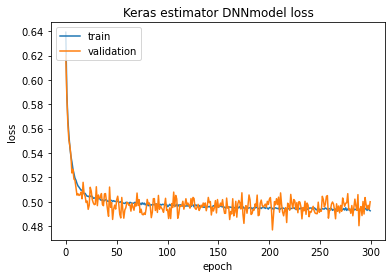

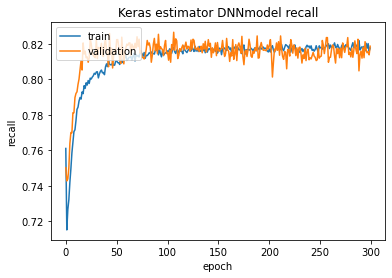

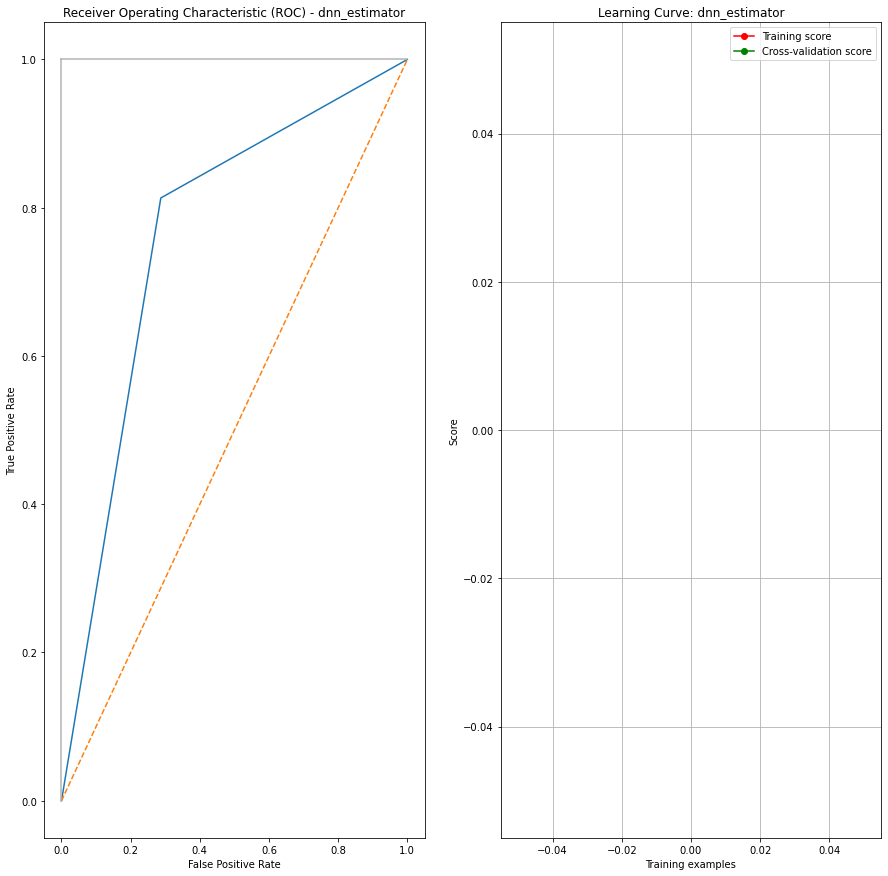

In [7]:
y_predicted_probas = model.predict(X_test)
y_predicted = (y_predicted_probas > 0.5).astype("int32")

print(model.summary())
print("number of ones predicted: {}".format(np.count_nonzero(y_predicted == 1)))
print("number of zeros predicted: {}".format(np.count_nonzero(y_predicted == 0)))
print_scores({estimator_name: get_scores(y_test, y_predicted)})

# plot loss and accuracy  
plot_loss(title=estimator_name, history=history)

# plot roc
number_of_rows, number_of_columns = 1, 2
figure_index = 1
figure = plt.figure(figsize=(15, 15))
ax = figure.add_subplot(number_of_rows, number_of_columns, figure_index)
plot_roc(title=estimator.name, ax=ax, y_test=y_test, y_predicted=y_predicted)
figure_index += 1

# plot learning curve
ax = figure.add_subplot(number_of_rows, number_of_columns, figure_index)
plot_learning_curve(title=estimator.name, estimator=estimator.value, ax=ax, X=X_train, y=y_train, cv=2)
figure_index += 1

## Logistic Regression

Fitting 2 folds for each of 27 candidates, totalling 54 fits
Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

log_regr_estimator           0.7417         0.7806         0.2181          0.341          0.515
Best parameters for log_regr_estimator: 
class_weight: {0: 0.5468029990852277, 1: 5.841538040003653}
max_iter: 200
solver: saga
Coefficient     |value     |
intercept       |-2.8209042864754195|
AlcoholDrinking |  -0.18298|
Stroke          |    1.2388|
DiffWalking     |   0.33367|
Sex             |  -0.74022|
AgeCategory     |   3.50266|
Diabetic        |   0.50805|
PhysicalActivity|   0.00372|
KidneyDisease   |   0.66044|
SkinCancer      |   0.12221|
breathing_risk  |   0.41598|
BMI_sqrt        |   0.06056|
GenHealth_squared|  -0.73752|
GenHealth_squared_x_Age|   0.29711|
GenHealth_squared_x_PhysicalHealth|  -0.13764|
PhysicalHealth__x_DiffWalking|  -0.03056|
PhysicalHealth_binned|   0.22706|


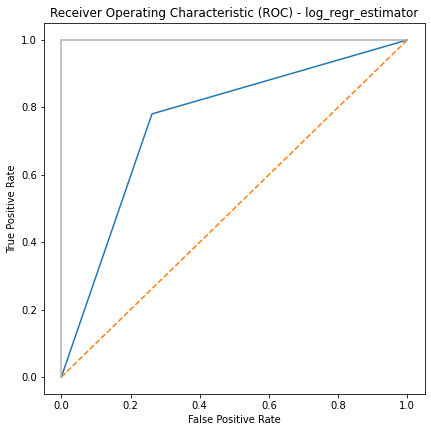

GridSearchCV(cv=2, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 4},
                                          {0: 0.5468029990852277,
                                           1: 5.841538040003653}],
                         'max_iter': [200, 400, 1000],
                         'solver': ['sag', 'saga', 'lbfgs']},
             return_train_score=True, scoring=make_scorer(fbeta_score, beta=2),
             verbose=3)

In [20]:
# logistic regression estimator
estimator = Estimator.log_regr_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict, cv_folds=2)

In [18]:
iters = 200
method = "lbfgs"
log_regr_model_statsmodels = sm.Logit(y_train,  sm.add_constant(X_train, prepend=False))
log_regr_res_statsmodels = log_regr_model_statsmodels.fit(maxiter=iters, method=method)
print(log_regr_res_statsmodels.summary())

odds_ratios = pd.DataFrame(
    {
        "OR": log_regr_res_statsmodels.params,
        "Lower CI": log_regr_res_statsmodels.conf_int()[0],
        "Upper CI": log_regr_res_statsmodels.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
print(odds_ratios)

                           Logit Regression Results                           
Dep. Variable:           HeartDisease   No. Observations:               255836
Model:                          Logit   Df Residuals:                   255819
Method:                           MLE   Df Model:                           16
Date:                Mon, 05 Dec 2022   Pseudo R-squ.:                  0.2214
Time:                        14:12:06   Log-Likelihood:                -58207.
converged:                       True   LL-Null:                       -74761.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
AlcoholDrinking                       -0.2015      0.037     -5.413      0.000      -0.274      -0.129
Stroke                                 1.0483      0.025   

In [9]:
print(log_regr_res_statsmodels.summary2())

                                   Results: Logit
Model:                    Logit                  Pseudo R-squared:       0.221      
Dependent Variable:       HeartDisease           AIC:                    116447.3740
Date:                     2022-12-05 14:05       BIC:                    116625.0630
No. Observations:         255836                 Log-Likelihood:         -58207.    
Df Model:                 16                     LL-Null:                -74761.    
Df Residuals:             255819                 LLR p-value:            0.0000     
Converged:                1.0000                 Scale:                  1.0000     
------------------------------------------------------------------------------------
                                    Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------------------
AlcoholDrinking                    -0.2016   0.0372   -5.4156 0.0000 -0.2745 -0.1286
Stroke         

In [17]:
y_pred = log_regr_res_statsmodels.predict(sm.add_constant(X_test, prepend=False))

decision_boundary = 0.1

y_pred.loc[y_pred >= decision_boundary] = 1
y_pred.loc[y_pred < decision_boundary] = 0

from sklearn.metrics import confusion_matrix
tn, fp, fn, tp= confusion_matrix(y_test, y_pred).ravel()

print("tp | {} fn: {}\nfp | {} tn: {}".format(tp, fn, fp, tn))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

f2 = fbeta_score(y_test, y_pred, beta=2, average='binary')
print("f2: {}".format(f2))

tp | 5391 fn: 84
fp | 44410 tn: 14074
              precision    recall  f1-score   support

           0       0.99      0.24      0.39     58484
           1       0.11      0.98      0.20      5475

    accuracy                           0.30     63959
   macro avg       0.55      0.61      0.29     63959
weighted avg       0.92      0.30      0.37     63959

f2: 0.3759361794117237
